In [2]:
import cv2
import time
from PIL import Image
import math
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from pathlib import Path

In [10]:
def svd(A):

    def multiplyScalarToVector(scale, vect):
        return scale * vect

    def getNormalisedVector(vector):
        length = np.linalg.norm(vector)
        return vector / length

    def getTranspose(A):
        return A.T

    def power_method(A, num_iter=1000, tol=1e-10):
        n = A.shape[0]
        b_k = np.random.rand(n)
        b_k /= np.linalg.norm(b_k)

        for _ in range(num_iter):
            b_k1 = A @ b_k
            b_k1 /= np.linalg.norm(b_k1)
            if np.linalg.norm(b_k1 - b_k) < tol:
                break
            b_k = b_k1

        eigenvalue = b_k.T @ (A @ b_k)
        return eigenvalue, b_k

    def getEigenValuesPower(A, k):
        A_copy = A.copy()
        eigenvalues = []
        eigenvectors = []
        for _ in range(k):
            eigval, eigvec = power_method(A_copy)
            eigenvalues.append(eigval)
            eigenvectors.append(eigvec)
            A_copy -= eigval * np.outer(eigvec, eigvec)
        return np.array(eigenvalues), np.array(eigenvectors).T

    def getSingularValues(eValues):
        return np.sqrt(np.abs(eValues))

    n, m = A.shape
    S = A @ A.T
    num_singular = min(n, m)

    eValues, eVectors = getEigenValuesPower(S, num_singular)
    singValues = getSingularValues(eValues)

    U = np.zeros((n, num_singular))
    V = np.zeros((m, num_singular))
    Sigma = np.zeros((num_singular, num_singular))

    for i in range(num_singular):
        U[:, i] = getNormalisedVector(eVectors[:, i])

    for i in range(num_singular):
        Sigma[i][i] = singValues[i]

    for i in range(num_singular):
        if singValues[i] != 0:
            V[:, i] = (A.T @ U[:, i]) / singValues[i]

    VT = getTranspose(V)
    return U, Sigma, VT


In [11]:
def pcp(M, convergence_rate, mu, maxiter=500):

    shape = M.shape  
    lam = 1.0 / np.sqrt(np.max(shape))
    norm = np.sum(M ** 2)
    i = 0
    rank = np.min(shape)

    S = np.zeros(shape)
    Y = np.zeros(shape)
    for i in range(maxiter):
        
       start = time.time()

       u, sigma, vt = svd(M - S + Y / mu)
       singular_values = np.diag(sigma)
       singular_values = shrink(singular_values, 1./mu)
       rank = np.sum(singular_values > 0.0)
       
       u = u[:, :rank]
       vt = vt[:rank, :]
       sigma = np.diag(singular_values[:rank])
       
       L = np.dot(u, np.dot(sigma, vt))
       S = shrink(M - L + Y / mu, lam / mu)
       
       step = M - L - S
       Y += mu * step

       error = np.sqrt(np.sum(step ** 2) / norm)
       iter_time = time.time() - start
       print(f"ITERATION -- {i}: error -- {error}, rank -- {rank}, time -- {iter_time} ")

       if error < convergence_rate:
            break
       i += 1

    return L, S


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

In [12]:
cap = cv2.VideoCapture('video_road.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w, h

(800, 600)

In [13]:
buf = np.empty((frameCount, h, w, 3), np.dtype('uint8'))

for fc in range(frameCount):
    try:
        ret, frame = cap.read()
        buf[fc] = cv2.resize(frame,(w,h), fx=0,fy=0, interpolation=cv2.INTER_CUBIC)
    except:
        break

M = buf[:,:,:,1].reshape((frameCount, w*h))

M.shape

(154, 480000)

In [14]:
mu = 0.25 * np.prod(M.shape) / np.sum(np.abs(M))
mu

np.float64(0.0023206315245777316)

In [16]:
L, S = pcp(M, 1e-6,mu, maxiter=70)

S.shape

ITERATION -- 0: error -- 0.026116757472344897, rank -- 148, time -- 18.013256549835205 
ITERATION -- 1: error -- 0.008609093068867396, rank -- 145, time -- 17.168760061264038 
ITERATION -- 2: error -- 0.00759250402273985, rank -- 134, time -- 17.963603734970093 
ITERATION -- 3: error -- 0.007581030177112693, rank -- 115, time -- 18.485846042633057 
ITERATION -- 4: error -- 0.007310060049707059, rank -- 98, time -- 18.726569414138794 
ITERATION -- 5: error -- 0.006920924742451034, rank -- 85, time -- 18.26830220222473 
ITERATION -- 6: error -- 0.006414144343937682, rank -- 75, time -- 15.392939805984497 
ITERATION -- 7: error -- 0.005950017090589025, rank -- 67, time -- 15.157682657241821 
ITERATION -- 8: error -- 0.0055179603450430156, rank -- 63, time -- 15.08778715133667 
ITERATION -- 9: error -- 0.005080889322971677, rank -- 61, time -- 15.270460605621338 
ITERATION -- 10: error -- 0.004672033930452498, rank -- 60, time -- 15.755098819732666 
ITERATION -- 11: error -- 0.004289559566

(154, 480000)

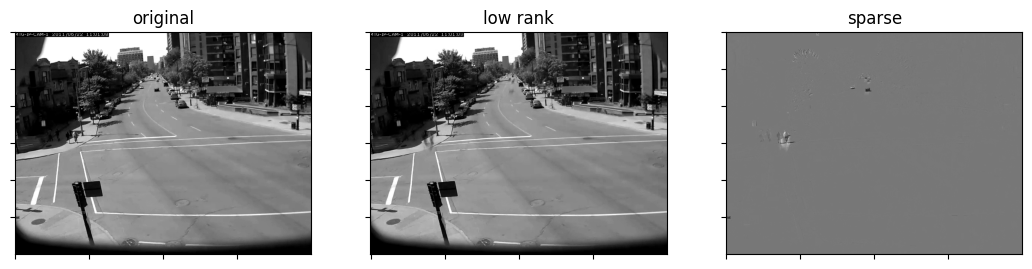

In [17]:
Path(os.getcwd() + "/output93/").mkdir(parents=True, exist_ok=True)

def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

shape = (h,w)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(M)-1):
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("original")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse")
    fig.savefig(f"output93/frame{i}.png")

In [18]:
def atoi(text):  
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

sorted_glob = sorted(glob.glob('output93/frame*.png'),key=natural_keys)



In [19]:
w = 1300
h = 400

In [20]:

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('output_video_result.mp4', fourcc, 20.0, (w,h))

for filename in sorted_glob:
    img = cv2.imread(filename)
    out.write(img)

out.release()